# Mark Correlation function

__Author__: Victor Calderon

__Date__  : 10/25/2017

---

## Mark Correlation Function - MCF

In the analysis of _galactic conformity_, we make use of the __mark correlation function__ (MCF; see [Skibba et al 2006](http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2966.2006.10196.x/abstract) for more information).

The MCF has the format of:

\begin{align}
\mathcal{M}(r_{p}) &= \frac{1 + W(r_{p})}{1 + \xi(r_{p})} \equiv \frac{WW}{DD}
\label{eq:mcf}
\end{align}

where $\xi(r_{p})$ is the usual two-point correlation function with pairs summed 
in bins of projected separation $r_{p}$, and $W (r_{p})$ is the same except 
that galaxy pairs are weighted by the product of their marks. The estimator 
used in Equation \ref{eq:mcf} can also be written as $WW/DD$, where $DD$ 
is the raw number of galaxy pairs separated by $r_{p}$ and $WW$ is the 
weighted number of pairs.

In the _conformity analysis_ using MCF, we normalize by the _mean_ of the galaxy property
and then compute the MCF results.

In this notebook, we will look at how different distributions can produce MCF values 
centered __around 1__.

---
## Testing different distributions

Now we will test different distributions, and look at their _MCF_ results.

In [174]:
## Importing modules
%matplotlib inline
import os
import numpy as np
from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import seaborn as sns
from tqdm import tqdm
sns.set('notebook',font_scale=1.5)

In [116]:
def choice_distribution(distr='gaussian', samples=10000, **kwargs):
    """
    Produces an array drawn from `distr`
    
    Parameters
    ----------
    distr: string, optional (default = 'gaussian')
        choice of distribution to use
        Options:
            - 'gaussian': Gaussian distribution with `mean`, `std`, and amplitude `A`
            - 'uniform' : Uniform distribution with `low`, `high`
            - 'binomial': Binomial distribution with `p`and `n`
            - 'poisson' : Poisson distribution with `lam`
            - 'double gaussian': Double gaussian with `A1`, `mean1`, `std1`, `A2`, `mean2`, `std2`
    
    samples: int, optional (default = 10000)
        total of number of samples to compute
    
    Returns
    --------
    data_arr: numpy.ndarray, shape(samples,)
        array of values from `distr` distribution
    """
    # Gaussian Distribution
    if distr=='gaussian':
        data_arr = kwargs['A']*random.normal(loc=kwargs['mean'], scale=kwargs['std'], size=samples)
    # Uniform Distribution
    if distr=='uniform':
        data_arr = random.uniform(low=kwargs['low'],high=kwargs['high'],size=samples)
    # Bimodal Distribution
    if distr=='binomial':
        data_arr = random.binomial(n=kwargs['n'], p=kwargs['p'], size=samples)
    # Poisson Distribution
    if distr=='poisson':
        data_arr = random.poisson(lam=kwargs['lam'], size=samples)
    # Double-Gaussian Distribution
    if distr=='double gaussian':
        gauss_1  = kwargs['A1']*random.normal(loc=kwargs['mean1'], scale=kwargs['std1'], size=kwargs['sample1'])
        gauss_2  = kwargs['A2']*random.normal(loc=kwargs['mean2'], scale=kwargs['std2'], size=kwargs['sample2'])
        data_arr = np.concatenate((gauss_1, gauss_2))
    
    return data_arr

### Plotting different distributions
 Now we can plot the different distributions that we want
 
 

In [262]:
def distr_plotting(data_dict, fig_dir=None, savefig=False, name=None, sharex=False, xlim=None):
    """
    Plots the distributions of `data_arr`
    
    Parameters:
    -----------
    data_arr: python dictionary
        dictionary containing values of different distributions
    
    fig_dir: string or None
        path to the `figures` directory
    
    savefig: boolean, optional (default = False)
        option to save the figure to the `fig_dir` folder.
    """
    ## Creating new figure
    ncols = 3
    nrows = 2
    if sharex:
        fig, axes = plt.subplots(nrows, ncols, facecolor='white', figsize=(15,10), sharex=True)
    else:
        fig, axes = plt.subplots(nrows, ncols, facecolor='white', figsize=(15,10))
    cmap = mpl.cm.autumn
    ## Looping over keys in `data_dict`
    for ii, key in enumerate(data_dict.keys()):
        ax      = axes.flatten()[ii]
        data_ii = data_dict[key]
        color   = cmap(ii / float(len(data_dict.keys())))
        sns.distplot(data_ii, label=key, ax=axes.flatten()[ii],color=color)
        ## Mean and St. Dev.
        ax.axvline(x=data_ii.mean(), label='Mean')
        ax.axvspan(data_ii.mean() - data_ii.std(), data_ii.mean()+data_ii.std(),
                    color=color,alpha=0.2, label='St. Dev')
        ax.legend(loc="upper left")
        ## Setting limits
        if xlim:
            ax.set_xlim(xlim)
    fig.suptitle(name)
    
    ## Saving figures
    if savefig:
        plt.savefig(os.path.join(fig_dir, 'MCF_distr_results_{0}.pdf'.format(name)))
    

Now we can use the function that computes the MCF results!

In [263]:
def MCF_analysis(data_arr, itern=1000, stat_func = np.nanmean, return_mean=False):
    """
    Computes the Marked Correlation function for `data_arr` and determines 
    the distribution of the shuffled scenario.
    
    Parameters
    ----------
    data_arr: numpy.ndarray, shape(n,)
        array of values from a given distribution
    
    itern: int, optional (default = 1000)
        number of iterations to determine the shuffles
    
    stat_func: numpy function, optional (default = numpy.nanmean)
        statistical function used to normalize `data_arr`
    
    return_mean: boolean, optional (default = False)
        option for return the `mean` and `St. Dev.` of the MCF.
    
    Return
    ----------
    mcf_sh: numpy.ndarray, shape(itern,)
        results from shuffling `data_arr` `itern` times
    
    mcf_mean: float
        mean of the `mcf_sh`
    
    mcf_std: float
        standard deviation of the `mcf_sh`
    """
    ## Resetting random seed
    random.seed()
    ## Normalizing `data_arr`
    data_norm = data_arr / stat_func(data_arr)
    ## Iterating `itern` times and determining the product of the values
    mcf_sh = [np.product(random.choice(data_norm,2)) for x in range(itern)]
    mcf_sh = np.asarray(mcf_sh)
    ## Mean and St. Dev
    mcf_mean = stat_func(data_arr)
    mcf_std  = np.std(data_arr)
    
    if return_mean:
        return mcf_sh, mcf_mean, mcf_std
    else:
        return mcf_sh


### Results from Shuffling the Distributions

Now we can plot the results from shuffling and determining the distributions from `data_arr`

In [264]:
mcf_sh_dict = {}

## Looping over all distributions
for ii, key in enumerate(data_dict.keys()):
    mcf_sh_dict[key] = MCF_analysis(data_dict[key])

## Plots

Now, we can create different plots to look at the distributions

In [267]:
### Pre-packaged initializers
distr_dict = {}
distr_dict['A'      ] = 10
distr_dict['mean'   ] = 10
distr_dict['std'    ] = 2.5
distr_dict['low'    ] = 10
distr_dict['high'   ] = 20
distr_dict['p'      ] = 0.5
distr_dict['n'      ] = 100
distr_dict['lam'    ] = 20
distr_dict['A1'     ] = 10
distr_dict['A2'     ] = 10
distr_dict['mean1'  ] = 20
distr_dict['mean2'  ] = 10
distr_dict['std1'   ] = 2
distr_dict['std2'   ] = 7
distr_dict['sample1'] = 1000
distr_dict['sample2'] = 2000
samples = 100000
itern   = 100000

## Computing `data` for each distribution
distr_names = ['gaussian','uniform','binomial','poisson','double gaussian']
data_dict   = {}
for distr_ii in distr_names:
    data_dict[distr_ii] = choice_distribution(distr=distr_ii, samples=samples, **distr_dict)

mcf_sh_dict = {}
## Looping over all distributions
for ii, key in enumerate(data_dict.keys()):
    (mcf_sh_dict[key],
     mcf_mean,
     mcf_std)= MCF_analysis(data_dict[key],itern=itern, return_mean=True)

## Saving Figures - Paths
fig_dir = os.path.join(os.path.realpath('./'),'figures')
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

No matter which configuration we choose for the different statistics, the mean is __always centered around 1__.

## SDSS DR7 Data

Now we can look at the data in SDSS DR7 and look at the distributions in `rp`.

In [268]:
import custom_utilities_python as cu

We will now read the `SDSS DR7` catalogue and look at the `sersic` of galaxies

In [269]:
## Reading in catalogue and `cleaning` it
DR7_catl = cu.sdss_catl_clean(
    cu.read_hdf5_file_to_pandas_DF(
        cu.extract_catls(catl_kind='data',catl_type='mr',sample_s='19',print_filedir=False)[0]),'data')

## Selecting only galaxies within a mass of 11.6 < M_h < 12.0
DR7_catl_m = DR7_catl.loc[(DR7_catl['M_h'] >= 11.6) & (DR7_catl['M_h'] < 12.)].reset_index()

print('There are {0} galaxies in this sample'.format(len(DR7_catl_m)))

There are 28272 galaxies in this sample


In [270]:
DR7_catl_m.head()

,level_0,index,JHU_NYU_index,M_g,M_h,M_h_PL,M_r,compl,cz,dec,...,galtype,groupid,logMstar_JHU,logMstar_JHU_flag,logMstar_bell,logsfr,logssfr,ra,redge,sersic
0,0,0,0,-19.1060,11.932883,12.012902,-20.0316,1.0000,16195.24,0.224026,...,1.0,0,10.551965,1,10.626023,-1.069466,-11.621430,38.049133,1.825,5.9033
1,10,10,10,-18.8998,11.697646,11.773739,-19.3481,1.0000,11119.14,0.459108,...,1.0,3,9.774231,1,9.829025,-0.444872,-10.219103,55.977487,0.733,0.9868
2,12,12,12,-19.0415,11.899062,11.978646,-19.9492,1.0000,16314.83,1.003827,...,1.0,5,10.608715,1,10.573427,-1.368571,-11.977286,37.895509,0.125,3.2187
3,22,22,22,-18.9876,11.722052,11.798431,-19.4283,1.0000,18097.97,1.031012,...,1.0,10,9.869938,1,9.852768,0.150434,-9.719504,42.785181,0.059,1.1406
4,35,35,35,-18.5328,11.629356,11.704699,-19.1212,0.9938,18462.29,0.966355,...,1.0,13,10.101055,1,9.891955,-0.022864,-10.123919,45.274376,0.255,1.9056


In [271]:
sersic_arr = DR7_catl_m.loc[:,'sersic'].values
sersic_arr.shape

## Adding sersic to `data_dict`
data_dict['sersic'] = sersic_arr

In [272]:
## Running MCF to `sersic`
mcf_sh_dict['sersic'] = MCF_analysis(sersic_arr, itern=itern, return_mean=False)

Now we can plot the distributions for all distributions

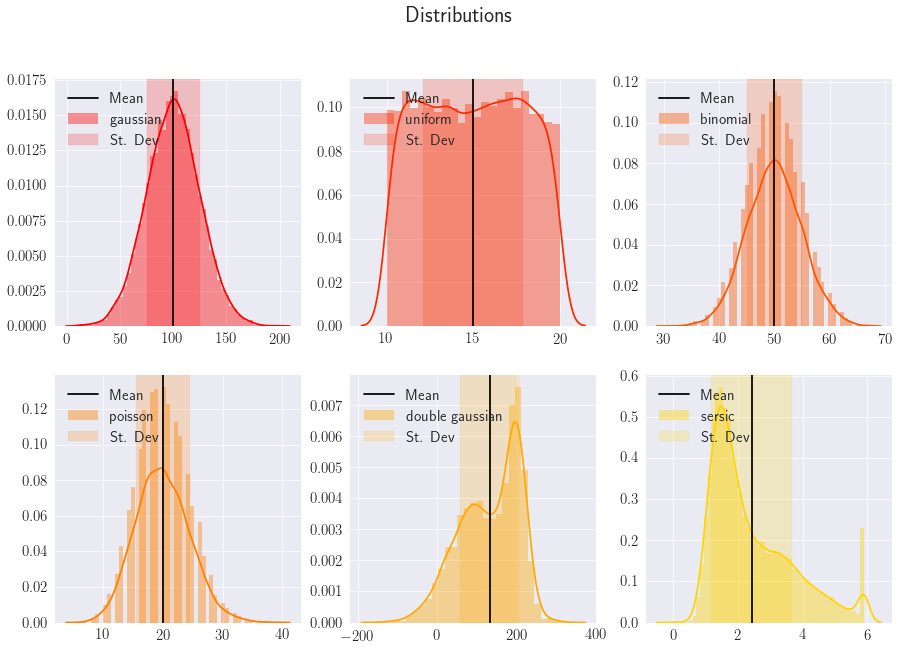

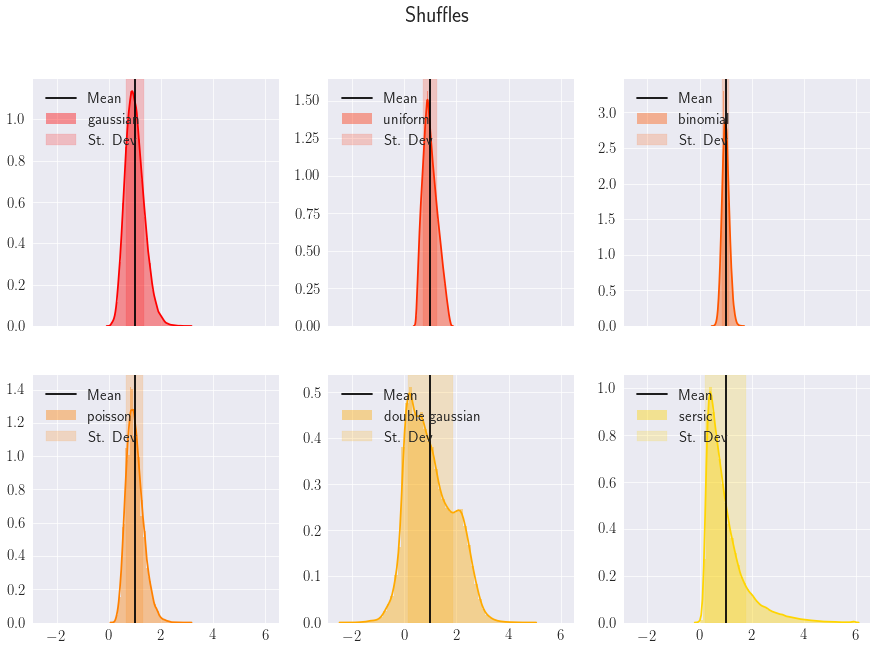

In [277]:
## Plotting results from Shuffling
distr_plotting(data_dict,fig_dir=fig_dir, savefig=True, name='Distributions')
distr_plotting(mcf_sh_dict, fig_dir=fig_dir, savefig=True, name='Shuffles', sharex=True)